In [18]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

import renom as rm
from renom.optimizer import Adam
from renom.cuda import set_cuda_active
# if you would like to use GPU, set True, otherwise you should be set to False
set_cuda_active(False)

In [19]:
def create_dataset(ds, look_back=1):
    X, y = [], []
    # look_back 分データをまとめるため、ループのインデックスはその分少なくなる
    for i in range(len(ds)-look_back):
        # 入力データは look_back 分でまとめられていく (e.g., 1949/1 - 1949/3)
        X.append(ds[i : i+look_back])
        # それに対する次の月の乗客数 (e.g., 1949/4)
        y.append(ds[i+look_back])
    X = np.reshape(np.array(X), [-1, look_back, 1])
    y = np.reshape(np.array(y), [-1, 1])
    return X, y

In [20]:
def split_data(X, y, test_size=0.1):
    pos = int(round(len(X) * (1-test_size)))
    # posまで
    X_train, y_train = X[:pos], y[:pos]
    # pos以降
    X_test, y_test = X[pos:], y[pos:]
    return X_train, y_train, X_test, y_test

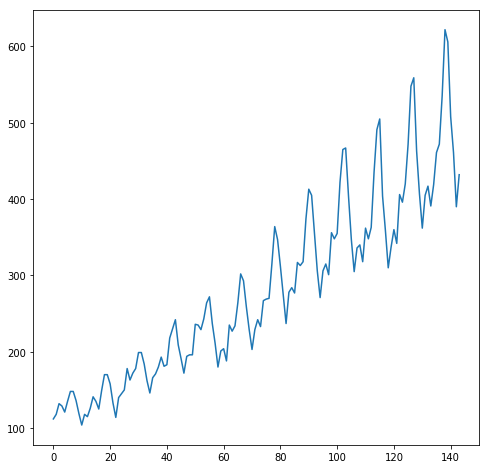

<Figure size 432x288 with 0 Axes>

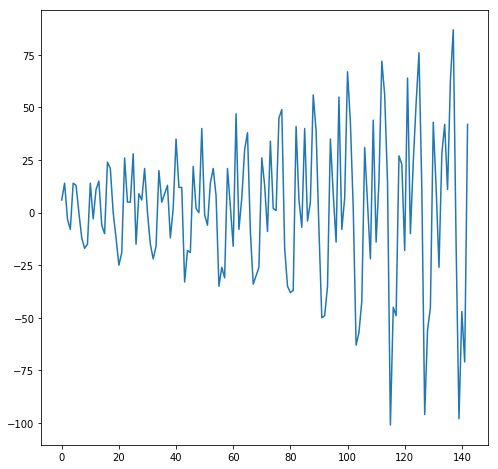

X:(140, 3, 1),y:(140, 1)
X_train:(94, 3, 1),y_train:(94, 1),X_test:(46, 3, 1),y:test(46, 1)


<Figure size 432x288 with 0 Axes>

In [21]:
df = pd.read_csv("./international-airline-passengers.csv",usecols=[1],header=None,skiprows=1,skipfooter=3,engine="python")
ds = df.values.astype("float32")
# print(ds)
# print(ds.shape)

# 毎月の乗客数を出力、横軸は1949年の1月が0、そこから1ずつカウントアップ
plt.figure(figsize=(8,8))
plt.plot(ds)
plt.show()
plt.clf()

data = []
for i in range(ds.shape[0]-1): # ds.shape[0]-1 = 143
    data.append(ds[i+1]-ds[i]) # i+1とiの月の乗客数の差分を配列に格納
data = np.array(data)
# print(data)

# 毎月の乗客数の増減を出力
plt.figure(figsize=(8,8))
plt.plot(data)
plt.show()
plt.clf()

# 学習を安定させるためにデータを正規化する
# 乗客数の増減の最小値と最大値を取得
v_min = np.min(np.abs(data))
v_max = np.max(np.abs(data))
# print(v_min)
# print(v_max)
# 毎月の乗客数の増減の最小値を0にする
data -= v_min
# print(data)
# 毎月の乗客数の増減を0-1の間に正規化
data /= v_max - v_min
# print(data)

# 3ヶ月間から次の月を予測
look_back = 3
X, y = create_dataset(data, look_back)
# print(X)
# print(y)
print("X:{},y:{}".format(X.shape, y.shape))
X_train, y_train, X_test, y_test = split_data(X, y, 0.33)
print("X_train:{},y_train:{},X_test:{},y:test{}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

In [22]:
sequential = rm.Sequential([
    # LSTM 層って言うのがある！！
    rm.Lstm(50),
    rm.Lstm(20),
    rm.Dense(1)
])

In [31]:
batch_size = 15
epoch = 800
N = len(X_train)
T = X_train.shape[1] # 予測で使用する期間 = 3ヶ月

learning_curve = []
test_learning_curve = []
optimizer = Adam(lr=0.001)
# epoch 毎の学習
for i in range(epoch):
    loss = 0
    test_loss = 0
    perm = np.random.permutation(N)
    # ミニバッチ毎の学習
    for j in range(N//batch_size):
        train_batch = X_train[perm[j*batch_size : (j+1)*batch_size]]
        response_batch = y_train[perm[j*batch_size : (j+1)*batch_size]]
        l = 0
        # 学習
        with sequential.train():
            # t = 0, 1, 2 でループ
            for t in range(T):
                z = sequential(train_batch[:, t, :])
                # Q. 結局最後の t = 2 の時の損失関数の値しか使っていないのでは？
                # l = rm.mse(z, response_batch)
                # 平均にしてみた
                l += rm.mse(z, response_batch)
                # print(l)
            # Q. 何をしているのかわからない
            sequential.truncate()
        # 平均にしてみた
        l = l / T
        l.grad().update(optimizer)
        loss += l.as_ndarray()

    # 推論
    l_test = 0
    for t in range(T):
        z = sequential(X_test[:, t, :])
        l_test = rm.mse(z, y_test)
    sequential.truncate()
    test_loss += l_test.as_ndarray()

    if i % 100 == 0:
        print("epoch:{:04d} loss:{:.5f} test_loss:{:.5f}".format(i, loss, test_loss))
    learning_curve.append(loss)
    test_learning_curve.append(test_loss)

epoch:0000 loss:0.10572 test_loss:0.11927
epoch:0100 loss:0.07855 test_loss:0.11824
epoch:0200 loss:0.06979 test_loss:0.11352
epoch:0300 loss:0.07594 test_loss:0.10987
epoch:0400 loss:0.07259 test_loss:0.10445
epoch:0500 loss:0.07087 test_loss:0.10570
epoch:0600 loss:0.06618 test_loss:0.10705
epoch:0700 loss:0.06514 test_loss:0.11373


Root mean squared error:49.654850006103516
2.847826
-6.8875566


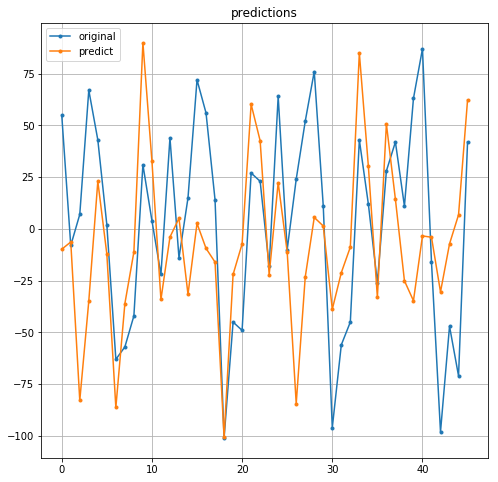

In [32]:
for t in range(T):
    test_predict = sequential(X_test[:, t, :])
sequential.truncate()

# 正規化から戻す
y_test_raw = y_test * (v_max - v_min) + v_min
test_predict = test_predict * (v_max - v_min) + v_min

print("Root mean squared error:{}".format(np.sqrt(mean_squared_error(y_test_raw, test_predict))))

print(np.average(y_test_raw))
print(np.average(test_predict))

plt.figure(figsize=(8,8))
plt.title("predictions")
plt.grid(True)
plt.plot(y_test_raw, marker=".", label ="original")
plt.plot(test_predict, marker=".", label="predict")

plt.legend()
plt.show("airline.png")